In [1]:
import os
import sys
from pathlib import Path
from dotenv import load_dotenv

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
env_path = Path(project_root) / ".env"
if env_path.exists():
    load_dotenv(dotenv_path=env_path)
else:
    load_dotenv()

DATA_DIR = Path().resolve().parent / "data"

if project_root not in sys.path:
    sys.path.insert(0, project_root)


In [36]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
from copy import deepcopy

from fredapi import Fred
from stargazer.stargazer import Stargazer

# 1. Data Processing

In [ ]:
# Some utils for data processing
def qdate_to_quarter(qdate_series):
    return (
        pd.PeriodIndex(qdate_series, freq='Q')
        .to_timestamp(how = 'end')
    )


def get_stats(res):
    return pd.Series({
        "coef": res.params['dFF_x_Bank_HHI'],
        "std_err": res.std_errors['dFF_x_Bank_HHI'],
        "t": res.tstats['dFF_x_Bank_HHI'],
        "pval": res.pvalues['dFF_x_Bank_HHI']
    }, name = 'dFF_x_Bank_HHI')


## (a) Read data 

In [4]:
pdf_data = pd.read_stata(
    DATA_DIR / "callreports_1976_2020_WRDS.dta"/ "callreports_1976_2020_WRDS.dta",
    # preserve_dtypes = False
    convert_dates = True,
    preserve_dtypes = False
)
pdf_data = pdf_data.dropna(subset=['cert', 'dateq'])
pdf_data['cert'] = pdf_data['cert'].astype('int64')
pdf_data['dateq'] = qdate_to_quarter(pdf_data['dateq'])
pdf_data['date'] = pd.to_datetime(pdf_data['date'], format='ISO8601')
# pdf_data['dateq'] = qdate_to_date(pdf_data)
# pdf_data['dateq'] = pd.to_datetime(pdf_data['dateq'], format='ISO8601')
# pdf_data['date'] = pd.to_datetime(pdf_data['date'], format='ISO8601')

In [5]:
pdf_data.head(1)

,rssdid,chartertype,cert,bhcid,date,name,assets,reloans,cash,persloans,...,intincnet,nonintexp,nonintinc,operinc,salaries,domdepservicecharges,tradingrevenue,intincreloans1to4fam,intexptimedeple250k,intexptimedepge250k
0,28.0,200.0,26606,0.0,1986-03-31,FIRST ATLANTIC BK,2779.0,0.0,1395.0,23.0,...,21.0,52.0,0.0,22.0,26.0,0.0,NaN,NaN,NaN,NaN


In [6]:
pdf_data[['dateq','cert']]

,dateq,cert
0,1986-03-31 23:59:59.999999999,26606
1,1986-06-30 23:59:59.999999999,26606
2,1986-09-30 23:59:59.999999999,26606
3,1986-12-31 23:59:59.999999999,26606
4,1987-03-31 23:59:59.999999999,26606
...,...,...
1919805,2019-12-31 23:59:59.999999999,59182
1919806,2020-03-31 23:59:59.999999999,59182
1919807,2019-12-31 23:59:59.999999999,59176
1919808,2020-03-31 23:59:59.999999999,59176


## (b). Merge with the Bank Herfindahl

In [7]:
# pdf_herf = pd.read_csv(
#     DATA_DIR / "l1_herfdepcty.csv"
# )
# pdf_herf = pdf_herf.dropna()
# pdf_herf['cert'] = pdf_herf['cert'].astype('int64')
# pdf_herf['dateq'] = qdate_to_quarter(pdf_herf['dateq'])

In [8]:
pdf_herf = pd.read_stata(
    DATA_DIR / "l1_herfdepcty.dta",
    convert_dates= True,
    preserve_dtypes= False
)
pdf_herf = pdf_herf.dropna()
pdf_herf['cert'] = pdf_herf['cert'].astype('int64')
pdf_herf['dateq'] = qdate_to_quarter(pdf_herf['dateq'])


In [9]:
pdf_herf.head(2)

,cert,dateq,l1_herfdepcty
39,8,1994-09-30 23:59:59.999999999,0.317719
40,8,1994-12-31 23:59:59.999999999,0.317719


In [187]:
pdf_merged = pdf_data.merge(
    pdf_herf,
    on=["cert", "dateq"],
    how="inner",
    suffixes=("", "_herf")
)


## (c) download Fed Funds rate from FRED and merge

Transformation done here: 
* Aggregate to quarterly values by taking the latest fed funds rate for each quarter. 
* Construct the change in fedfunds rate $\Delta FF_t = FFR_t - FFR_{t-1}$


In [11]:
# Fetch FRED data
fread = Fred(api_key = os.getenv("API_KEY_FRED"))
pds_ffs = fread.get_series("FEDFUNDS")
pds_ffs.name = "fedfunds"
pds_ffs.index.name = "date"
pdf_ffs = pds_ffs.to_frame().reset_index()
pdf_ffs['date'] = pd.to_datetime(pdf_ffs['date'], format='YYYY-MM-DD')
pdf_ffs['dateq'] = qdate_to_quarter(pdf_ffs['date'])


In [188]:
# Filter to quarterly frequency 
pdf_ffsq = (
    pdf_ffs.sort_values('date')
    .groupby('dateq', as_index=False)['fedfunds']
    .last()
)
pdf_ffsq['fedfunds'] = pdf_ffsq['fedfunds'].div(100)
pdf_ffsq['d_fedfunds'] = pdf_ffsq['fedfunds'].diff()

In [189]:
pdf_merged = pdf_merged.merge(
    pdf_ffsq,
    on=["dateq"],
    how="inner"
)

## (d) Construct Table 8 variables



Remove ouliers as follows

In [191]:
nonneg_cols = ['deposits','timedep','liabilities','assets','cash','securities','loans']
nonneg_mask = np.all([np.greater(pdf_merged[col], 0) for col in nonneg_cols], axis = 0)


In [192]:
np.sum(nonneg_mask)

np.int64(502417)

In [194]:
pdf_merged.head().to_clipboard()

In [198]:
pdf_merged.shape

(584601, 190)

In [197]:
(pdf_merged['chartertype'] != 200).sum()

np.int64(9)

In [ ]:
# Filter some values
# (1) Remove zero problems with log diffs
# (2) Remove one oulier 1996-03-31 cert 33260 that has deposits 15, dep interest 3403.0 (huge dep rate)
nonneg_cols = ['deposits']#,'totsavdep', 'timedep','liabilities','assets','cash','securities','loans']
nonneg_mask = [np.greater(pdf_merged[col], 0) for col in nonneg_cols]
pdf_merged = pdf_merged[np.all(np.array(nonneg_mask).T, axis = 1)]
pdf_merged = pdf_merged[pdf_merged['chartertype'] == 200]
pdf_merged = pdf_merged[
    ~((pdf_merged['dateq'] == pd.to_datetime("1996-03-31 23:59:59.999999999")) 
    &(pdf_merged['cert'] == 33260))]

In [204]:
pdf_merged.shape

(584439, 190)

The following variables are constructed
* XXX
* Deposit spread, calculated with average deposits, produces similar standard erros as with paper

In [205]:
# log change in domestic deposits
def groupbed_log_diff(pdf, value_col, group_col = 'cert'):
    return np.log(pdf[value_col] / (pdf.groupby(group_col)[value_col].shift(1)))

# Panel A dep-vals (bank liabilities)
pdf_merged['d_total_deposits_A'] = groupbed_log_diff(pdf_merged, 'deposits')
pdf_merged['d_savings_deposits_A'] = groupbed_log_diff(pdf_merged, 'totsavdep')
pdf_merged['d_time_deposits_A'] = groupbed_log_diff(pdf_merged, 'timedep') # check
pdf_merged['wholesale_funding'] = pdf_merged['liabilities'] - pdf_merged['deposits'] # check
# pdf_merged["wholesale_funding"] = (
#     pdf_merged["fed_funds_purchased"]     # RCONB993
#     + pdf_merged["repos_sold"]            # RCONB995
#     + pdf_merged["other_borrowed_money"]  # RCON2800
#     + pdf_merged["subordinated_debt"]     # RCON3548
# )
pdf_merged['d_wholesale_funding_A'] = groupbed_log_diff(pdf_merged, 'wholesale_funding')
pdf_merged['d_liabilities_A'] = groupbed_log_diff(pdf_merged, 'liabilities')

# Panel B dep-vals (bank assets)
pdf_merged['d_total_assets_B'] = groupbed_log_diff(pdf_merged, 'assets')
pdf_merged['d_cash_B'] = groupbed_log_diff(pdf_merged, 'cash')
pdf_merged['d_securities_B'] = groupbed_log_diff(pdf_merged, 'securities')
pdf_merged['d_total_loans_B'] = groupbed_log_diff(pdf_merged, 'loans')
pdf_merged['d_real_estate_loans_B'] = groupbed_log_diff(pdf_merged, 'reloans') # check that has values
pdf_merged['d_ciloans_B'] = groupbed_log_diff(pdf_merged, 'ciloans')

c:\Users\palmunen\PR\git\financial_econometrics_II\env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\palmunen\PR\git\financial_econometrics_II\env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\palmunen\PR\git\financial_econometrics_II\env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\palmunen\PR\git\financial_econometrics_II\env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\palmunen\PR\git\financial_econometrics_II\env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc,

In [219]:
# Deposit spread based on annualized (x 4) domestic deposits and domestic expenses, 
# even thouth the annualization is not needed for regrs
# avg deposits produce matching values with the paper
pdf_merged['deposits_lag'] = pdf_merged.groupby(['cert'])['deposits'].shift(1)
pdf_merged['avg_deposits'] = (pdf_merged['deposits'] + pdf_merged['deposits_lag']) / 2
pdf_merged['dep_rate'] = 4 * pdf_merged['intexpdomdep'] / pdf_merged['avg_deposits']
pdf_merged['deposit_spread'] = pdf_merged['fedfunds'] - pdf_merged['dep_rate']
pdf_merged['d_deposit_spread_A'] = pdf_merged.groupby('cert')['deposit_spread'].diff()
pdf_merged.dropna(inplace = True, subset=['d_deposit_spread_A'])

In [220]:
# Fixed effects related, mentioned in the footnote
pdf_merged["post_2008"] = (pdf_merged["dateq"] >= pd.to_datetime("2009-01-01")).astype(int)
pdf_merged["fe_bank_post2008"] = pdf_merged["cert"].astype(str) + "_" + pdf_merged["post_2008"].astype(str)
# pdf_merged["bank_fe_combo"] = pdf_merged["cert"].astype(str) + "_" + pdf_merged["post_2008"].astype(str)

# 2. Fit Regression Models

In [221]:
pdf_regr = deepcopy(pdf_merged)
pdf_regr['bank_hhi'] = pdf_regr['l1_herfdepcty']
pdf_regr['dFF_x_Bank_HHI'] = pdf_regr['d_fedfunds'] * pdf_regr['bank_hhi']
pdf_regr.set_index(['cert', 'dateq'], inplace=True)

## d) Run the regressions

In [ ]:
# Dependent variables table A 
all_vars = pdf_regr.columns
depvars_a = pdf_regr.columns[all_vars.str.startswith('d_') & all_vars.str.endswith('_A')].tolist()
depvars_b = pdf_regr.columns[all_vars.str.startswith('d_') & all_vars.str.endswith('_B')].tolist()
depvars = depvars_a + depvars_b

In [275]:
def table8_reg(df, depvar, entity_effects = False, time_effects = True, other_effects = ["fe_bank_post2008"]):

    mask = df[depvar].notnull() & np.isfinite(df[depvar])
    df = df.loc[mask]
    y = df[depvar]
    X = df[["dFF_x_Bank_HHI", "bank_hhi"]]
    
    mod = PanelOLS(
        y,
        X,
        entity_effects=entity_effects,        
        time_effects=time_effects,
        other_effects= None if other_effects is None else df[other_effects]
    )


    clusters = pd.Series(
        df.index.get_level_values("cert"), 
        index=df.index, name="cert"
    )

    res = mod.fit(
        cov_type="clustered",
        clusters=clusters
    )

    return res

In [276]:
res_panel = {dep_val: table8_reg(pdf_regr, dep_val) for dep_val in depvars}

In [278]:
for name, res in res_panel.items():
    print(f"\n=== Regression: {name} ===\n")
    # Try to print the neatly formatted summary
    try:
        print(res.summary)
    except Exception:
        # Fallback to str(res)
        print(res)



=== Regression: d_total_deposits_A ===

                          PanelOLS Estimation Summary                           
Dep. Variable:     d_total_deposits_A   R-squared:                     9.764e-05
Estimator:                   PanelOLS   R-squared (Between):              0.0174
No. Observations:              560868   R-squared (Within):               0.0007
Date:                Thu, Dec 11 2025   R-squared (Overall):              0.0033
Time:                        00:41:44   Log-likelihood                 4.285e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      26.488
Entities:                       11487   P-value                           0.0000
Avg Obs:                       48.826   Distribution:                F(2,542528)
Min Obs:                       1.0000                                           
Max Obs:                       76.000   F-statistic (robust):       

## e) The role of fixed effects 
Iterate through all the combinations, {(firm effects), (time effects), (firm effects * 2008_ind), (firm effects, time effects)}

In [258]:
kwargs_to_iterate = {
    'entity': {'entity_effects': True, 'time_effects': False, 'other_effects': None},
    'time': {'entity_effects': False, 'time_effects': True, 'other_effects': None},
    'timeX2008': {'entity_effects': False, 'time_effects': False, 'other_effects': ["fe_bank_post2008"]},
    'entityXtime': {'entity_effects': True, 'time_effects': True, 'other_effects': None},
    'entityXtimeX2008': {'entity_effects': False, 'time_effects': True, 'other_effects': ["fe_bank_post2008"]}, # the base case with all specified fixed effecs
}

In [260]:
fe_results = {}
for key, kwargs in kwargs_to_iterate.items():
    res_panel = {dep_val: get_stats(table8_reg(pdf_regr, dep_val, **kwargs)) for dep_val in depvars}
    fe_results[key] = pd.DataFrame(res_panel)


In [273]:
fe_results

{'entity':          d_total_deposits_A  d_savings_deposits_A  d_time_deposits_A  \
 coef              -2.549993             -6.223547           0.680084   
 std_err            0.122611              0.165437           0.155758   
 t                -20.797503            -37.618819           4.366284   
 pval               0.000000              0.000000           0.000013   
 
          d_wholesale_funding_A  d_liabilities_A  d_deposit_spread_A  \
 coef                  8.149486        -2.373888            2.499412   
 std_err               0.581792         0.107111            0.025261   
 t                    14.007562       -22.162775           98.943435   
 pval                  0.000000         0.000000            0.000000   
 
          d_total_assets_B   d_cash_B  d_securities_B  d_total_loans_B  \
 coef            -1.971063 -18.540374       -0.733317         1.501056   
 std_err          0.096652   0.426953        0.244743         0.129162   
 t              -20.393477 -43.424871  

## f) Robustness Checks

Results upto and including 2007Q4

In [ ]:
pdf_regr2008 =pdf_regr.loc[
    pdf_regr.index.get_level_values('dateq') < pd.to_datetime('2008-01-01')
] 
res_panel_robust2008 = {dep_val: table8_reg(
        pdf_regr2008, 
        dep_val
    )
    for dep_val in depvars
}

In [266]:
for name, res in res_panel_robust2008.items():
    print(f"\n=== Regression: {name} ===\n")
    try:
        print(res.summary)
    except Exception as e:
        print(f"Could not display summary for {name}: {e}")


=== Regression: d_total_deposits_A ===

                          PanelOLS Estimation Summary                           
Dep. Variable:     d_total_deposits_A   R-squared:                     3.014e-05
Estimator:                   PanelOLS   R-squared (Between):             -0.0114
No. Observations:              406597   R-squared (Within):               0.0005
Date:                Wed, Dec 10 2025   R-squared (Overall):             -0.0017
Time:                        23:58:35   Log-likelihood                 2.932e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5.9604
Entities:                       11057   P-value                           0.0026
Avg Obs:                       36.773   Distribution:                F(2,395485)
Min Obs:                       1.0000                                           
Max Obs:                       54.000   F-statistic (robust):       

Analysis with largest 10% of banks

In [267]:
pds_average_assets = pdf_regr.groupby('cert')['assets'].mean()
top_10_cert = pds_average_assets[pds_average_assets > np.quantile(pds_average_assets, 0.90)].index
pdf_regr_top10 = pdf_regr.loc[
    pdf_regr.index.get_level_values('cert').isin(top_10_cert)
]
res_panel_robust_top10 = {dep_val: table8_reg(
        pdf_regr_top10, dep_val
    )
    for dep_val in depvars
}

In [268]:
for name, res in res_panel_robust_top10.items():
    print(f"\n=== Regression: {name} ===\n")
    try:
        print(res.summary)
    except Exception as e:
        print(f"Could not display summary for {name}: {e}")


=== Regression: d_total_deposits_A ===

                          PanelOLS Estimation Summary                           
Dep. Variable:     d_total_deposits_A   R-squared:                     9.707e-05
Estimator:                   PanelOLS   R-squared (Between):              0.0771
No. Observations:               49637   R-squared (Within):            9.515e-05
Date:                Thu, Dec 11 2025   R-squared (Overall):              0.0069
Time:                        00:16:18   Log-likelihood                    6013.8
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2.3233
Entities:                        1149   P-value                           0.0980
Avg Obs:                       43.200   Distribution:                 F(2,47865)
Min Obs:                       1.0000                                           
Max Obs:                       76.000   F-statistic (robust):       

Analysis with largest 25% of banks

In [269]:
top_25_cert = pds_average_assets[pds_average_assets > np.quantile(pds_average_assets, 0.75)].index
pdf_regr_top25 = pdf_regr.loc[
    pdf_regr.index.get_level_values('cert').isin(top_25_cert)
]
res_panel_robust_top25 = {dep_val: table8_reg(
        pdf_regr_top25, dep_val
    )
    for dep_val in depvars
}

In [270]:
for name, res in res_panel_robust_top25.items():
    print(f"\n=== Regression: {name} ===\n")
    try:
        print(res.summary)
    except Exception as e:
        print(f"Could not display summary for {name}: {e}")


=== Regression: d_total_deposits_A ===

                          PanelOLS Estimation Summary                           
Dep. Variable:     d_total_deposits_A   R-squared:                        0.0002
Estimator:                   PanelOLS   R-squared (Between):             -0.0306
No. Observations:              133880   R-squared (Within):            1.834e-05
Date:                Thu, Dec 11 2025   R-squared (Overall):             -0.0043
Time:                        00:27:59   Log-likelihood                 5.515e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      10.085
Entities:                        2872   P-value                           0.0000
Avg Obs:                       46.616   Distribution:                F(2,129351)
Min Obs:                       1.0000                                           
Max Obs:                       76.000   F-statistic (robust):       

# A. Descriptive stats to see that transformations match with the paper

<Axes: xlabel='dateq'>

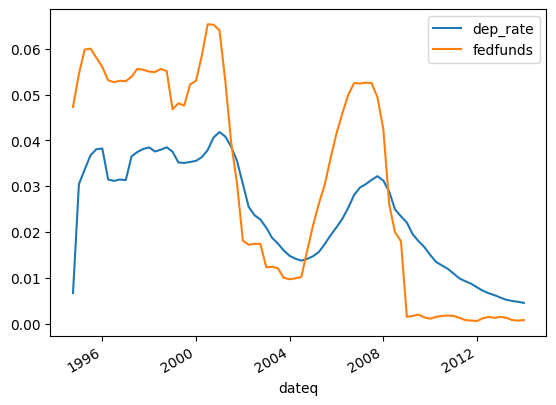

In [228]:
temp_mean = pdf_merged.groupby('dateq')[['dep_rate', 'fedfunds']].mean()
temp_mean.plot()

In [229]:
temp_outlier = pdf_merged[pdf_merged['dateq'] == temp_mean[np.equal(temp_mean['dep_rate'], temp_mean['dep_rate'].max())].index[0]]
temp_outlier[temp_outlier['dep_rate'] == temp_outlier['dep_rate'].max()][['dateq', 'cert']]#.to_clipboard()

,dateq,cert
445256,2000-12-31 23:59:59.999999999,21626


# 2. Table Replication/Analysis 

In [230]:
# example (no filepath)
from stargazer.stargazer import Stargazer
import statsmodels.api as sm
import pandas as pd

In [231]:
for res in results_list:
    print(res.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:       d_total_assets_B   R-squared:                     4.523e-05
Estimator:                   PanelOLS   R-squared (Between):              0.0207
No. Observations:              572614   R-squared (Within):               0.0006
Date:                Wed, Dec 10 2025   R-squared (Overall):              0.0057
Time:                        21:12:45   Log-likelihood                 5.918e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      12.683
Entities:                       11695   P-value                           0.0000
Avg Obs:                       48.962   Distribution:                F(2,560840)
Min Obs:                       1.0000                                           
Max Obs:                       81.000   F-statistic (robust):             9.5062
                            